In [6]:

import os
import cv2
import sys
from scipy import io
import pandas as pd
from scipy.spatial import distance
import numpy as np
import math
import matplotlib.pyplot as plt
import glob
import fracture

def make_mask(path):
    class PolygonDrawer(object):
        def __init__(self, window_name):
            self.window_name = window_name # Name for our window
            self.done = False # Flag signalling we're done
            self.current = (0, 0) # Current position, so we can draw the line-in-progress
            self.points = [] # List of points defining our polygon

        def on_mouse(self, event, x, y, buttons, user_param):
            # Mouse callback that gets called for every mouse event (i.e. moving, clicking, etc.)
            if self.done: # Nothing more to do
                return
            if event == cv2.EVENT_MOUSEMOVE:
                # We want to be able to draw the line-in-progress, so update current mouse position
                self.current = (x, y)
            elif event == cv2.EVENT_LBUTTONDOWN:
                # Left click means adding a point at current position to the list of points
                # print("Adding point #%d with position(%d,%d)" % (len(self.points), x, y))
                self.points.append((x, y))
            elif event == cv2.EVENT_RBUTTONDOWN:
                # Right click means we're done
                print("Completing polygon with %d points." % len(self.points))
                self.done = True

        def run(self):
            # Let's create our working window and set a mouse callback to handle events
            cv2.namedWindow(self.window_name)
            cv2.imshow(self.window_name, np.zeros(CANVAS_SIZE, np.uint8))
            cv2.waitKey(1)
            cv2.setMouseCallback(self.window_name, self.on_mouse)

            while(not self.done):
                # This is our drawing loop, we just continuously draw new images
                # and show them in the named window
                canvas = images[i]
                if (len(self.points) > 0):
                    # Draw all the current polygon segments
                    cv2.polylines(canvas, np.array([self.points]), False, (255, 255, 255), 1)
                    # And  also show what the current segment would look like
                    # cv2.line(canvas, self.points[-1], self.current, WORKING_LINE_COLOR)
                # Update the window
                cv2.imshow(self.window_name, canvas)
                # And wait 50ms before next iteration (this will pump window messages meanwhile)
                if cv2.waitKey(50) == 27: # ESC hit
                    self.done = True
            # User finised entering the polygon points, so let's make the final drawing
            canvas = images[i]
            # of a filled polygon
            if (len(self.points) > 0):
                cv2.fillPoly(canvas, np.array([self.points]), (255, 255, 255))
                # print(np.array([self.points]))
            # And show it
            cv2.imshow(self.window_name, canvas)
            # Waiting for the user to press any key
            cv2.waitKey()
            cv2.destroyWindow(self.window_name)
            return canvas, self.points

    # file_list = os.listdir(path)
    # img = [file for file in file_list if file.endswith(".jpg")]
    # image = cv2.imread(path+'/'+img[num], cv2.IMREAD_GRAYSCALE)
    images = load_file(path,flip='flip')

    # if image is None:
    #     print('Image load failed!')
    #     sys.exit()
    for i in images:
        x, y, w, h = cv2.selectROI(images[i])
        cv2.destroyAllWindows()

        cv2.rectangle(images[i], (x,y), (x+w,y+h),(0,0,0),2)
        CANVAS_SIZE = np.shape(images[i])

        poly = PolygonDrawer("Polygon")
        _, poly_points = poly.run()

        ##mask part
        mask = np.zeros(np.shape(images[i]))
        mask[y:y+h, x:x+w] = 255
        cv2.fillPoly(mask, np.array([poly_points]), (0,0,0))
        cv2.imshow('mask', mask)

        #%% save part
        cv2.imwrite(path+'/'+str(i)+'_mask.png',mask)
        cv2.waitKey()
        cv2.destroyAllWindows()
    return

class Crack_tip():
    def __init__(self, ratio):
        """ x, y 는 좌표, point 는 리스트로 x,y좌표 모아줌, count는 좌표 몇개, 길이, 1픽셀당 mm(mm/1픽셀)"""
        self.x = 0
        self.y =0
        self.point = []
        self.count= -1
        self.length = 0
        self.ratio = ratio
        self.df = pd.DataFrame(index = range(0,3), columns=['index', 'length',  'length(add)', 'x', 'y'])
        return

    def inital(self, x, y):
        self.x = x
        self.y= y
        self.point.append([[x,y]])
        self.df.loc[0] = [self.count+1, 0 , 0 , x, y]
        self.count +=1


    def append(self, x, y):
        self.x =x
        self.y= y
        self.point.append([[x,y]])
        self.count +=1
        self.length = distance.cdist(self.point[self.count-1], self.point[self.count]) * self.ratio
        self.df.loc[self.count] = [self.count, self.length ,self.length + self.df["length(add)"][self.count-1], x, y]

    def position(self):
        return self.point

    def all_position(self):
        return self.df
    pass


def ASTM_E399(Pq,a,B,W):
    """B is thickness(cm), W is width(cm), Pq is stress(kN), A is crack length(cm)"""
    f_in = a/W
    f=((2+f_in)*(0.886+4.64*f_in-13.32*(f_in**2)+14.72*(f_in**3)-5.6*(f_in**4)))/((1-f_in)**1.5)
    kq=(Pq*f)/(B*(W**0.5))
    return kq

def hookes_law_sigmayy(YoungsModulus, Poisson, strain_xx, strain_yy):
    sigma_yy = YoungsModulus*(strain_xx*Poisson + strain_yy)/(1-Poisson**2)
    return sigma_yy

def Williams_sigmayy(r, theta):
    theta = math.radians(theta)
    K1_coefficient = np.cos(theta/2) * (1 + np.sin(theta/2) * np.sin(3 * theta / 2)) / (2 * np.pi * r) ** 0.5
    K2_coefficient = np.sin(theta/2) * np.cos(theta/2) * np.cos(3*theta/2) / (2 * np.pi * r) ** 0.5
    return [K1_coefficient, K2_coefficient]

def cart2pol(x, y):
    """out put : dgree, rho"""
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    degree = np.rad2deg(phi).reshape([-1,1])
    out = np. hstack((rho,degree))
    return out

def pol2cart(rho, degree):
    """in put : degree, rho"""
    phi = np.deg2rad(degree).reshape([-1,1])
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    out = np.hstack((x, y))
    return out

def circle_location(radius, ratio):
    """
    첫번째 원점에서 떨어져있는 값 radius 반지름길이임
    예상각도 수정하고 싶으면 np.arrange 안에 각도 바꿔주면됨
    ratio : mm/pixel , output mm
    x , y 좌표 , rad, theta(degree)
   """
    degree = np.arange(-60, 60+5 ,5)
    degree = degree.reshape([-1,1])
    rho = np.ones([degree.shape[0],1]) * radius
    xy = pol2cart(rho, degree).round()
    rtheta = np.hstack((degree, rho * ratio))
    out = np.hstack((xy, rtheta))
    return out

def find_zone(array):
    """
    :param array: 일반 배열받음
    :return: 주위로 둘러쌓인 0값을 제거하고 행렬 반환
    """
    y_axis = np.nonzero(array)[0]
    x_axis = np.nonzero(array)[1]
    y_min, y_max = np.min(y_axis), np.max(y_axis)
    x_min, x_max = np.min(x_axis), np.max(x_axis)
    result = array[y_min:y_max, x_min:x_max]
    return result

def u_f1(r, theta):
    shear_modulus = 26900 #unit:mpa
    poisson_ratio = 0.33
    n = 1
    theta = np.deg2rad(theta)
    plane_stress= (3 - poisson_ratio)/(1 + poisson_ratio)
    plane_strain = 3 - 4 * poisson_ratio

    result = r**(n/2) * (plane_stress + n/2 + (-1)**n * np.cos(n/2 * theta) - n/2*np.cos((n/2 - 2) * theta)) / (2 * shear_modulus)
    return result

def u_f2(r, theta):
    shear_modulus = 26900 #unit:mpa
    poisson_ratio = 0.33
    n = 1
    theta = np.deg2rad(theta)
    plane_stress= (3 - poisson_ratio)/(1 + poisson_ratio)
    plane_strain = 3 - 4 * poisson_ratio

    result = r**(n/2) * (plane_stress + n/2 -(-1)**n * np.sin(n/2*theta) - 0.5*n*np.sin((n/2-2)*theta)) / (2 * shear_modulus)
    return result

def v_f1(r, theta):
    shear_modulus = 26900 #unit:mpa
    poisson_ratio = 0.33
    n = 1
    theta = np.deg2rad(theta)
    plane_stress= (3 - poisson_ratio)/(1 + poisson_ratio)
    plane_strain = 3 - 4 * poisson_ratio

    result = r**(n/2) * (plane_stress - n/2 -(-1)**n * np.sin(n/2 * theta) + n/2*np.sin((n/2 -2)*theta)) / (2 * shear_modulus)
    return result

def v_f2(r, theta):
    shear_modulus = 26900 #unit:mpa
    poisson_ratio = 0.33
    n = 1
    theta = np.deg2rad(theta)
    plane_stress= (3 - poisson_ratio)/(1 + poisson_ratio)
    plane_strain = 3 - 4 * poisson_ratio

    result = r**(n/2) * (-1 * plane_stress + n/2 -(-1)**n * np.cos(n/2 *theta) - 0.5*n*np.cos((n/2 - 2)  * theta)) / (2 * shear_modulus)
    return result

def load_file(path, flip = 'None'):
    """ 폴더에 들어간 순서대로 이미지 추가 Dict형태 좌우 반전시 flip = 'flip' 사용"""
    files = glob.glob(path+'./*.jpg')
    if not files:
        print("Chck Phath")
        sys.exit()
    img = {}
    for i in files:
        im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
        name = os.path.split(os.path.splitext(i)[0])[-1]
        if flip == 'flip':
            im = cv2.flip(im, 1)
        img.setdefault('%s'%name,im)
    return img



"""
step1. make mask reference, current

"""

##이미지 로드
path = r'E:\experiment data\aluminum\2021-01-28\number1(dic)\DIC'
# make_mask(path)
img = load_file(path,flip='')



In [8]:
"""
step2.
#mat save code
exx = handles_ncorr.data_dic.strains.plot_exx_cur_formatted
eyy = handles_ncorr.data_dic.strains.plot_eyy_cur_formatted
exy = handles_ncorr.data_dic.strains.plot_exy_cur_formatted
uu = handles_ncorr.data_dic.displacements.plot_u_cur_formatted
vv = handles_ncorr.data_dic.displacements.plot_v_cur_formatted
roi_cur = handles_ncorr.data_dic.strains.roi_cur_formatted
"""
file_num = '/3301'

uu = io.loadmat(path+file_num+'/uu.mat')['uu']
vv = io.loadmat(path+file_num+'/vv.mat')['vv']
exx = io.loadmat(path+file_num+'/exx.mat')['exx']
eyy = io.loadmat(path+file_num+'/eyy.mat')['eyy']
exy = io.loadmat(path+file_num+'/exy.mat')['exy']
ee = fracture.effective_strain(exx, eyy, exy)
np.savetxt(path+file_num+'/ee.csv',ee)
ee_resize = cv2.resize(ee,(0,0),fx=2, fy=2 )
uu_resize = cv2.resize(uu,(0,0),fx=2, fy=2 )
vv_resize = cv2.resize(vv,(0,0),fx=2, fy=2 )

In [ ]:
"""
step3. set crack tip
"""
c_tip = Crack_tip(0.030303)
c_tip.inital(167, 350)
# c_tip.append(437, 407)
c_tip.all_position()
c_tip.position()[0][0]

In [ ]:
"""
step4. select point
"""
radius = 30
radius_gap = 5
ratio = 0.030303

count = 0
radius_g = 0
for _ in range(20):
    if count == 0:
        location = circle_location(radius, ratio)
        radius_g += radius_gap
        count += 1
    else:

        location = np.vstack((location, circle_location(radius+radius_g, ratio)))
        radius_g += radius_gap



plt.imshow(ee_resize, cmap='gray')

# print(ref_xywh)
# y_ratio = cur_xywh[3]/np.shape(u_zone)[0]
# x_ratio = cur_xywh[2]/np.shape(u_zone)[1]
zone_cracktip_x = c_tip.position()[0][0][0]
zone_cracktip_y = c_tip.position()[0][0][1]
dot_x = zone_cracktip_x
dot_y = zone_cracktip_y
# file_list = os.listdir(path)
# img = [file for file in file_list if file.endswith(".jpg")]
# image = cv2.imread(path+'/'+img[1], cv2.IMREAD_GRAYSCALE)
#

# plt.scatter(c_tip.position()[1][0][0], c_tip.position()[1][0][1], c = 'red')
plt.scatter( dot_x, dot_y, s = 0.5,  c = 'red')
plt.scatter(location[:,0]+dot_x,location[:,1]+dot_y, s = 0.1,  c='red')

In [ ]:
h = []
h_u, h_v = [], []

b = []
b_u = [0,0,0,0,0]
b_v = [0,0,0,0,0]

for x, y, degree, rho in location:
    dis_u = uu_resize[int(np.round(y+dot_y))][int(np.round(x +dot_x))]
    dis_v = vv_resize[int(np.round(y+dot_y))][int(np.round(x +dot_x))]
    h_u = np.append(h_u, (dis_u)*0.001)
    h_v = np.append(h_v, (dis_v)*0.001)
    b_u = np.vstack((b_u,[u_f1(rho*0.001,degree), u_f2(rho*0.001,degree)*-1,
                     1,0,-1 * y*0.0303*0.001]))
    b_v = np.vstack((b_v,[v_f1(rho*0.001,degree), v_f2(rho*0.001,degree)*-1,
                     0,1,x*0.0303*0.001]))
    # print(dis_u, dis_v, h_u, h_v)

h= np.hstack((h_v,h_u))
h = np.reshape(h,(-1,1))
b = np.vstack((b_u[1:,],b_v[1:,]))
b
h

K = np.dot( np.dot( np.linalg.inv( np.dot(np.transpose(b), b)) , np.transpose(b)) , h) * (2 * np.pi)**0.5
K

In [ ]:
img.keys()

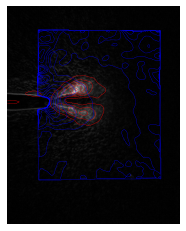

In [9]:
src1 = img['ff3301']
src2 = img['ff3302']

dst = cv2.absdiff(src1, src2)
plt.imshow(dst,cmap = 'gray')
gas = cv2.GaussianBlur(dst,(0,0),10)
plt.contour(gas, colors='red', linewidths=0.3)
plt.axis('off')

cv2.flip(ee_resize,1,ee_resize)
plt.contour(ee_resize, levels=10, colors='blue', linewidths=0.3)
plt.savefig(path+file_num+'/gg.png', transparent=True, dpi=300)


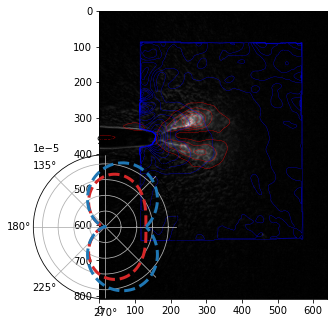

In [10]:
import matplotlib.pyplot as plt
pz = fracture.Plastic_zone(74,503)
SIF_K1= 74
yeild_strength = 503
theta = np.arange(0, 2*np.pi, .01)[1:]




"""von mises criterion"""
von_mises = (1+np.cos(theta)+1.5*np.sin(theta)**2)*(1/(4*np.pi)*(SIF_K1/yeild_strength)**2)
tresca = SIF_K1**2/(2*np.pi*yeild_strength**2)*(np.cos(theta/2)*(1+np.sin(theta/2)))**2

fig = plt.gcf()

img_coords = [0, 0, 1, 1]
axes_coords = [0, 0, 0.5, 0.5] # plotting full width and height
ax_image = fig.add_axes(img_coords, label="ax image")
ax_image.imshow(dst,cmap='gray')
ax_image.contour(gas, colors='red', linewidths=0.3)
ax_image.contour(ee_resize, levels=10, colors='blue', linewidths=0.3)

ax_polar = fig.add_axes(axes_coords, projection='polar', label="ax polar")

ax_polar.plot(theta, von_mises*0.001*15, color="tab:red", ls="--", lw=3, label="von mises" )
ax_polar.plot(theta, tresca*0.001*15, color="tab:blue", ls="--", lw=3, label="Tresca" )
ax_polar.patch.set_alpha(0)
# ax_polar.set_rlabel_position(100)
# ax_polar.axis('off')

plt.show()

In [11]:

pz.von_mises()[0]
von_deg = np.rad2deg(pz.von_mises()[1])

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
       1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21,
       1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
       1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.